In [2]:
#new embedding method

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation

import numpy as np



class LDAembedder(object):

    def __init__(self, **kwargs):

        if kwargs:

            self.vectorizer = kwargs['counter']

            self.feature_names = self.vectorizer.get_feature_names()

            self.lda_model = model

        else:

            if kwargs['max_features']:

                max_features = kwargs['max_features']

            else:

                max_features = 100000

            self.vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', max_features = max_features)

            self.feature_names = None

            self.lda_model = None





    def display_topics(self, n_top_words, topic_n = None):

        '''

        Display the top n words for each topic in the model.



        Input:

            n_top_words(int) : the number of words to display for each topic

            (Optional)

            topic_n(int) : if specified, only diplay the topic_nth topic

        '''

        model = self.lda_model

        feature_names = self.feature_names



        if model and feature_names:

            if topic_n:

                topic = model.components_[topic_n]

                print("Topic %d:" % topic_n)

                print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))

            else:

                for topic_index, topic in enumerate(model.components_):

                    print("Topic %d:" % topic_index)

                    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))

        else:

            raise Exception('You have to train before display')





    def fit(self, texts, n = 100):

        '''

        Train the LDA with n number of topics



        Input:

            texts(list) : list of documents. Each item in the list is a string type

            n(int) : number of topics, if not specified n = 100

        '''

        count = self.vectorizer.fit_transform(texts)

        self.feature_names = self.vectorizer.get_feature_names()

        model = LatentDirichletAllocation(n_topics=n).fit(count)

        self.lda_model = model



    def embed(self, text, method = 'additive'):

        '''

        embed the review text into k-dimensional topic vector



        Input:

            text(string) : a document to embed

            method(string) : 'additive' or 'multiplicative'



        Output:

            the vector of length k (k = number of topics)

        '''

        tokenizer = self.vectorizer.build_analyzer()

        count = self.vectorizer.transform(tokenizer(text))



        dirich = self.lda_model.transform(count)

        if method == 'additive':

            total = np.array([1]*dirich[0])

            for i in dirich:

                total = np.add(total, i)

            return total / sum(total)

        elif method == 'multiplicative':

            product = np.array([1]*dirich[0])

            for i in dirich:

                product = np.multiply(product, i)

            return product / sum(product)

        else:

            return dirich

In [3]:
path1 = "C:\\Users\\cdchang\\chinese.pkl"
path2 = "C:\\Users\\cdchang\\chinese_counter.pkl"

In [32]:
#testing the new embedder

import nltk
import pickle

# load the pre-trained model
with open(path2, "rb") as f:
    vectorizer = pickle.load(f)
with open(path1, "rb") as f:
    model = pickle.load(f)

lda = LDAembedder(model = model, counter = vectorizer)

# print top 10 words from each topic
lda.display_topics(10)

# embed text
sample = 'This place is horrible, we were so excited to try it since I got a gift card for my birthday. We went in an ordered are whole meal and they did not except are gift card, because their system was down. Unacceptable, this would have been so helpful if we would have known this prior!!'

add = lda.embed(sample, 'additive')
prod = lda.embed(sample, 'multiplicative')

print(add[0])

C:\Users\cdchang\Anaconda3\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\cdchang\Anaconda3\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Topic 0:
location los new angeles judge book like restaurant cover lucky
Topic 1:
steak eggs rare bo pho like good meatballs hue medium
Topic 2:
english chinese speak food mandarin menu don like really language
Topic 3:
cantonese chinese tin just restaurant silver summerlin gigantic road laws
Topic 4:
milk coffee tea bread breakfast came drink toast like ham
Topic 5:
shrimp fried rice great walnut food chicken honey house good
Topic 6:
sour chicken sweet hot soup kung pao good hakka food
Topic 7:
really place food good chinese nice just try surprised mom
Topic 8:
congee fried rice queen dough turnip place food preserved chinese
Topic 9:
options variety choose fresh meat veggies lots choices meats menu
Topic 10:
wonderful mother family great fin shark dinner nest divine food
Topic 11:
ho pizza mi flavours waffle sandwich banh waffles loving sandwiches
Topic 12:
shrimp rice pork mai siu fried steamed ribs egg har
Topic 13:
chicken food ordered like sauce just meat tasted soggy dry
Topic 

In [6]:
#re-did k-index embeddings on Chinese reviews
import json
import pandas as pd

def json_df(datapass):
    '''
    Load the json file and parse the file to pandas dataframe format
    
    Input:
        datapass(str) : directory to the json file
    Output:
        df(dataframe) : pandas dataframe object
    '''
    
    data = [] 
    with open(datapass, 'r', encoding='utf-8') as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

#business and review json files --> dataframes

DATAPASS1 = 'C:\\Users\\cdchang\\Downloads\\yelp_dataset\\dataset\\business.json'
DATAPASS2 = 'C:\\Users\\cdchang\\Downloads\\yelp_dataset\\dataset\\review.json'

business = json_df(DATAPASS1)
#reviews = json_df(DATAPASS2)

In [7]:
#old methods from past weeks

def business_id_retrieval(cat, business):
    '''
    Input:
        cat(str) : category
        business(dataframe) : the business data
    Output:
        id_list(set) : business ids of a particular category
    '''
    id_list = set()
    id_list = []
    idx = 0
    for row in business.values:
        categories = row[3]
        if cat in categories:
            id_list.append(row[2])
            
    return id_list

def examine_reviews2(cat, business, reviews):
    '''
    concatenate a category's review text with the corresponding dates for time series analysis
    Input: specific category, review json file
    Output: concatenated review text & date columns for a particular category (not business specific) 
    '''
    id_list = business_id_retrieval(cat, business)
    return reviews.loc[reviews['business_id'].isin(id_list)]

def examine_reviews(b_id, reviews):
    '''
    concatenate a particular business's review text with the corresponding dates for time series analysis
    
    Input: specific business id, review json file
    Output: concatenated review text & date columns for a particular business id
    '''
    subset = reviews.loc[reviews['business_id'] == b_id]
    date = subset.loc[:, 'date']
    text = subset.loc[:, 'text']
    return pd.concat([date, text], axis=1, join='inner')



In [47]:
#Chinese restaurant feature extraction 
#OVERARCHING OBJECTIVE: for a single business, find the most popular topic


#filter out the reviews with 100+ reviews

#for every business: for every topic out of 127 topics, find the range and keep track of the highest topic index
#do this across all businesses

ids = business_id_retrieval("Chinese", business)
pop_topic_list = []
for i in ids[0:1000]:
    collection = examine_reviews(i, reviews)

    s = collection.sort_values(by="date") #sorting by timestamp
    text = s.loc[:, 'text']
    topic_nums = []
    topic_eval = []


    for t in text: #for every review
        temp = []
        add = lda.embed(t, 'additive') #get index array for that particular review
        temp = add.tolist()
        max_num = max(add)   #get max of the index array
        
        
            
        topic_nums.append(max_num)
        topic_eval.append(temp.index(max_num)) #topic evals contain all the max #s
        
    final_index = topic_nums.index(max(topic_nums)) #verdict for an entire business
    
    pop_topic_list.append(final_index)
    
pop_topic_list
#histogram of frequency of "most popular" topic
#this will be used as the feature in the classifier

[2,
 0,
 0,
 15,
 0,
 1,
 0,
 11,
 1,
 209,
 18,
 0,
 0,
 10,
 3,
 19,
 9,
 2,
 13,
 1,
 6,
 73,
 27,
 30,
 0,
 2,
 15,
 1,
 271,
 2,
 13,
 1,
 15,
 58,
 5,
 19,
 0,
 4,
 1,
 7,
 69,
 2,
 2,
 75,
 2,
 143,
 21,
 82,
 19,
 1,
 15,
 9,
 4,
 4,
 24,
 18,
 15,
 8,
 5,
 21,
 1,
 2,
 5,
 8,
 17,
 3,
 46,
 5,
 45,
 11,
 44,
 0,
 15,
 3,
 82,
 0,
 41,
 0,
 43,
 13,
 6,
 18,
 260,
 7,
 1,
 0,
 3,
 2,
 7,
 22,
 2,
 3,
 22,
 17,
 44,
 4,
 19,
 1,
 1,
 4,
 17,
 8,
 2,
 22,
 7,
 13,
 48,
 17,
 8,
 33,
 3,
 3,
 1,
 8,
 38,
 138,
 35,
 19,
 6,
 24,
 60,
 26,
 4,
 12,
 2,
 22,
 21,
 110,
 10,
 49,
 1,
 10,
 79,
 4,
 2,
 26,
 70,
 41,
 29,
 6,
 2,
 21,
 4,
 2,
 117,
 21,
 149,
 22,
 79,
 10,
 7,
 20,
 8,
 6,
 1,
 7,
 69,
 4,
 2,
 0,
 11,
 10,
 6,
 1,
 30,
 65,
 3,
 11,
 3,
 20,
 3,
 12,
 3,
 44,
 2,
 87,
 16,
 1,
 221,
 0,
 5,
 56,
 0,
 27,
 10,
 49,
 4,
 5,
 19,
 9,
 11,
 17,
 0,
 5,
 2,
 0,
 57,
 20,
 16,
 17,
 1,
 136,
 2,
 3,
 5,
 8,
 10,
 1,
 4,
 7,
 2,
 0,
 113,
 6,
 1,
 17,
 80,
 3,
 60,
 21,
 4

In [49]:
#histogram set-up (first 500)
freq_count = {}
for num in pop_topic_list:
    if num not in freq_count:
        freq_count[num] = 0
    else:
        freq_count[num] +=1

freq_count

{0: 68,
 1: 77,
 2: 87,
 3: 62,
 4: 61,
 5: 40,
 6: 42,
 7: 33,
 8: 29,
 9: 32,
 10: 29,
 11: 17,
 12: 18,
 13: 17,
 14: 10,
 15: 18,
 16: 6,
 17: 11,
 18: 19,
 19: 13,
 20: 12,
 21: 13,
 22: 11,
 23: 16,
 24: 9,
 25: 7,
 26: 7,
 27: 7,
 28: 1,
 29: 4,
 30: 3,
 31: 1,
 32: 4,
 33: 4,
 34: 0,
 35: 1,
 36: 3,
 37: 2,
 38: 1,
 40: 1,
 41: 6,
 42: 5,
 43: 1,
 44: 3,
 45: 1,
 46: 3,
 47: 0,
 48: 4,
 49: 5,
 50: 0,
 51: 4,
 53: 2,
 54: 3,
 56: 0,
 57: 1,
 58: 1,
 59: 1,
 60: 3,
 61: 2,
 62: 1,
 63: 0,
 64: 2,
 65: 0,
 66: 0,
 67: 0,
 68: 2,
 69: 2,
 70: 1,
 72: 0,
 73: 2,
 74: 1,
 75: 0,
 76: 1,
 77: 0,
 78: 1,
 79: 1,
 80: 1,
 81: 0,
 82: 1,
 84: 0,
 86: 1,
 87: 1,
 88: 0,
 89: 0,
 90: 1,
 91: 0,
 92: 0,
 93: 1,
 94: 0,
 95: 3,
 96: 0,
 98: 0,
 99: 0,
 103: 0,
 107: 1,
 108: 0,
 109: 0,
 110: 1,
 111: 0,
 113: 1,
 116: 0,
 117: 1,
 118: 1,
 122: 0,
 123: 0,
 127: 0,
 136: 1,
 138: 0,
 143: 1,
 146: 0,
 149: 0,
 152: 0,
 161: 1,
 167: 0,
 204: 0,
 209: 0,
 216: 0,
 221: 0,
 238: 0,
 249: 0,


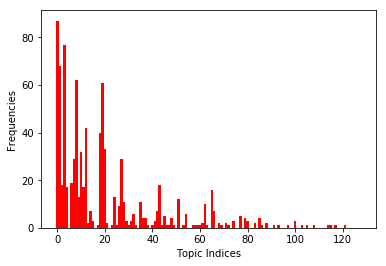

In [55]:
import numpy as np
import matplotlib.pyplot as plt

indices = freq_count.keys()
frequencies = freq_count.values()

pos = np.arange(len(indices))
width = 1.0     # gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xlabel("Topic Indices")
ax.set_ylabel("Frequencies")
#ax.set_xticks(pos + (width / 2))
#ax.set_xticklabels(indices)

plt.bar(pos, frequencies, width, color='r')
plt.show()

92
Estimated intercept coefficient:  3.00397960797
Number of coefficients:  3


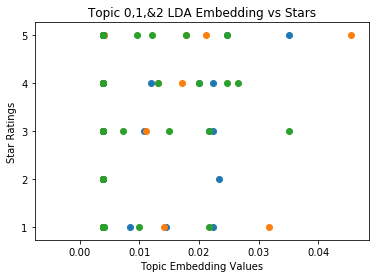

In [81]:
#multi-variable linear regression (with Chinese this time!)
#case study: jQsNFOzDpxPmOurSWCg1vQ
from sklearn.linear_model import LinearRegression

#examine_reviews2("Chinese", business, reviews)
subset = reviews.loc[reviews['business_id']=="jQsNFOzDpxPmOurSWCg1vQ"]
date = subset.loc[:,'date']
text = subset.loc[:,'text']
stars = subset.loc[:,'stars']

topic0 = []
topic1 = []
topic2 = []

#generate the topic 0, 1, 2 columns (with index values)

for t in text: #for every review
    add = lda.embed(t, 'additive')
    temp = add.tolist()
    topic0.append(temp[0]) #appending k index embeddings
    topic1.append(temp[1])
    topic2.append(temp[2])

topic0_n = np.array(topic0)
topic1_n = np.array(topic1)
topic2_n = np.array(topic2)

d = {'date': date, 'topic0': topic0, 'topic1': topic1, 'topic2': topic2, 'stars': stars}
df = pd.DataFrame(data=d)
d_X = {'topic0': topic0, 'topic1': topic1, 'topic2': topic2} #multiple features
df_X = pd.DataFrame(data=d_X)

lm = LinearRegression()
lm.fit(df_X,df.stars)

print('Estimated intercept coefficient: ', lm.intercept_)
print('Number of coefficients: ', len(lm.coef_)) #3 since there are 3 features

plt.scatter(df.topic0, df.stars)
plt.scatter(df.topic1, df.stars) #orange
plt.scatter(df.topic2, df.stars) #green

plt.xlabel("Topic Embedding Values")
plt.ylabel("Star Ratings")
plt.title("Topic 0,1,&2 LDA Embedding vs Stars")
plt.show()

In [97]:
#prediction code begins here:

#lm.predict(df_X)[0:5]
#plt.scatter(df.stars, lm.predict(df_X))
#plt.scatter(df.stars, df.stars)
#plt.show()

#mse using multiple features
mseFull = np.mean((df.stars - lm.predict(df_X))**2)
print(mseFull) #2.0353734 

lm = LinearRegression()
lm.fit(df_X[["topic1"]], df.stars)

mseSingle = np.mean((df.stars - lm.predict(df_X[["topic0"]]))**2)
print(mseSingle)

#not that much of a difference

2.035373421313286
2.0690626194739115


In [115]:
#test and train
import sklearn 
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

X_train = df_X[:-10]
X_test = df_X[-10:]
Y_train = df.stars[:-10]
Y_test = df.stars[-10:]

regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)
y_pred = regr.predict(X_test)
plt.scatter(X_test, Y_test, color='black')

ValueError: x and y must be the same size

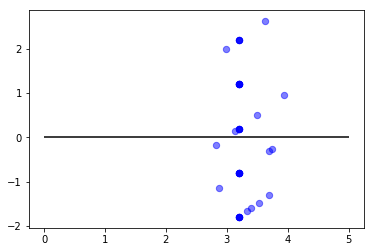

In [110]:
#test and train
#RESIDUAL PLOT
import sklearn.cross_validation


#X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(df_X, df.stars, test_size=0.33, random_state=5)

lm = LinearRegression()
lm.fit(X_train, Y_train)
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)

plt.scatter(lm.predict(X_train), lm.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
#plt.scatter(lm.predict(X_test), lm.predict(X_test)-Y_test, c='g', s=40)
plt.hlines(y=0, xmin=0, xmax=5)
plt.show()

In [111]:
df

,date,stars,topic0,topic1,topic2
16,2017-06-03,1,0.003906,0.003906,0.003906
17,2015-03-26,4,0.003906,0.017064,0.003906
18,2012-12-30,5,0.003970,0.003970,0.012167
19,2009-01-12,3,0.010709,0.003906,0.007308
20,2015-07-11,3,0.003906,0.003906,0.035156
21,2015-05-27,1,0.003906,0.003906,0.003906
22,2015-02-28,5,0.003906,0.003906,0.003906
23,2010-04-05,4,0.003906,0.003906,0.003906
24,2015-05-22,1,0.014433,0.003906,0.003906
25,2011-06-15,2,0.003906,0.003906,0.003906


In [ ]:
#review count code

def review_count(reviews, business):
    reviewtotal = {}
    for row in reviews:
        idx = 0
        if row[0] in business.business_id: #if review is in business
            review_section = get_reviews_idonly(row[0]) #get reviews from specific business id
            reviewtotal[row[0]] = len(review_section)   #save # of reviews
            
    reviewtotal = reviewtotal.sorted(reviewtotal.items(), key=lambda x: x[1], reverse = True)   
    return reviewtotal

#get_reviews("Pizza", business)
#review_count(reviews, business)
idlist = list()
listing = business_id_retrieval("Pizza", business)
for l in listing:
    x = get_reviews_idonly(l)
    idlist.append(x)
    if (len(x) > 100):
        idlist.append(l)